# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
    - [Multicolinearity - VIF](#Multicolinearity---VIF)
- [Clustering](#Clustering)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches.csv')
data.drop(columns = ['Unnamed: 0'], inplace = True) 
data.dropna(inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head(5)

(680887, 27)


,pitch_type,velo,spin_rate,spin_axis,pfx_-x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_-x,plate_x,plate_z,swing_miss,delta_run_exp,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value
0,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,1.40,6.80,6.5,54.03,0.69,-0.69,2.83,0,-0.073,13.0,95.2,-13.0,2.0,0.174,0.158,0.0,1.0,0.0,0.0
1,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,1.60,6.64,6.4,54.15,0.71,-0.71,2.62,0,-0.027,108.0,75.3,75.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
2,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,1.46,6.88,6.2,54.34,0.04,-0.04,2.46,0,-0.020,157.0,83.5,65.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
3,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,1.53,6.83,5.9,54.61,-2.10,2.10,3.89,0,0.016,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0
4,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,1.49,6.66,6.3,54.15,0.31,-0.31,2.80,0,-0.189,9.0,93.3,-18.0,2.0,0.100,0.090,0.0,1.0,0.0,0.0


Pitch Types:

4-Seam, Cutter, Sinker, Slider, Curveball, Changeup

# Preprocessing

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(27)

,feature,VIF
14,swing_miss,1.436037e+00
7,release_pos_x,1.711329e+00
18,launch_angle,2.512807e+00
3,pfx_-x,3.458728e+00
15,delta_run_exp,3.935160e+00
24,babip_value,5.173555e+00
17,exit_velo,5.178644e+00
23,woba_denom,5.194367e+00
4,pfx_z,5.370648e+00
25,iso_value,5.935403e+00


# Features

In [4]:
features = data[['velo', 'pfx_-x', 'pfx_z', 'delta_run_exp', 
                 'woba_value', 'plate_x', 'plate_z', 'pitch_type']]

ff = features.loc[features['pitch_type'] == 'FF']
print('4-seam shape:', ff.shape)
fc = features.loc[features['pitch_type'] == 'FC']
print('Cutter shape:', fc.shape)
si = features.loc[features['pitch_type'] == 'SI']
print('Sinker shape:', si.shape)
sl = features.loc[features['pitch_type'] == 'SL']
print('Slider shape:', sl.shape)
cu = features.loc[features['pitch_type'] == 'CU']
print('Curveball shape:', cu.shape)
ch = features.loc[features['pitch_type'] == 'CH']
print('Changeup shape:', ch.shape)

4-seam shape: (249672, 8)
Cutter shape: (47442, 8)
Sinker shape: (109145, 8)
Slider shape: (135539, 8)
Curveball shape: (58767, 8)
Changeup shape: (80322, 8)


# Clustering 

## 4-Seam Fastball

In [5]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca_ff = PCA().fit_transform(X_ff_scaled) # X_ff_scaled
model_ff = pd.DataFrame(data = pca_ff, columns = X_ff.columns)

km_ff = KMeans(n_clusters = 2, 
               random_state = 1)
km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print('Predicted clusters to points: ', label_ff[:10], '\n')

Number of iterations: 24
Number of features: 7
Number of clusters: 2
Inertia: 1424797.4302240366 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - 4-Seam

In [6]:
# 0 good, 1 bad

X_ff['label'] = label_ff
model_ff['label'] = label_ff
#model_ff.groupby(by = 'label').mean().T
X_ff.groupby(by = 'label').mean().T

label,0,1
velo,93.709321,93.613378
pfx_-x,2.846771,2.778358
pfx_z,16.138414,15.708836
delta_run_exp,-0.048176,0.522770
woba_value,0.000332,1.009910
plate_x,0.004738,-0.028969
plate_z,2.755221,2.616340


### Heatmaps of Features - 4-Seam

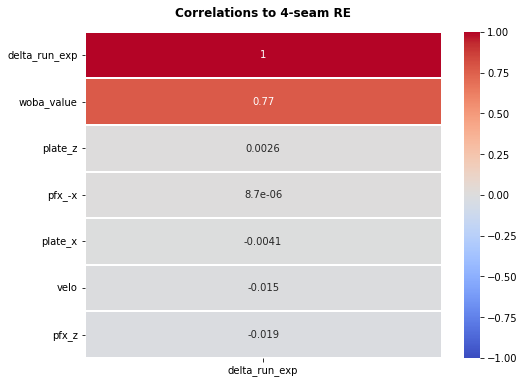

In [7]:
plt.figure(figsize = (8, 6))
sns.heatmap(ff.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam RE', fontweight = 'bold', pad = 15);

Positively correlated with label, as the positive values increase the run exp increases

Negatively correlated with lablel, as the negative values increase the run exp decreases and vice versa

Positively correlated with label, as the positive values increase the label increases

Negatively correlated with lablel, as the negative values increase the label decreases and vice versa

## Cutter

In [8]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

#X_fc_scaled = ss.fit_transform(X_fc)
#X_fc_scaled[:,:] *= -1

pca_fc = PCA().fit(X_fc) # X_fc_scaled
principal_components_fc = pca_fc.transform(X_fc) # X_fc_scaled
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')

Number of iterations: 10
Number of features: 7
Number of clusters: 2
Inertia: 1560316.2224547956 

Predicted clusters to points:  [1 0 0 1 0 0 0 0 0 1] 



### Cluster Labels - Cutter

In [9]:
# 0 good, 1 bad

X_fc['label'] = label_fc
model_fc['label'] = label_fc

X_fc.groupby(by = 'label').mean().T

label,0,1
velo,86.861087,90.751834
pfx_-x,-1.294488,-1.496073
pfx_z,5.347334,11.366731
delta_run_exp,-0.001147,0.000324
woba_value,0.085248,0.085419
plate_x,0.127956,0.200255
plate_z,2.262973,2.412979


### Heatmap of Features - Cutter

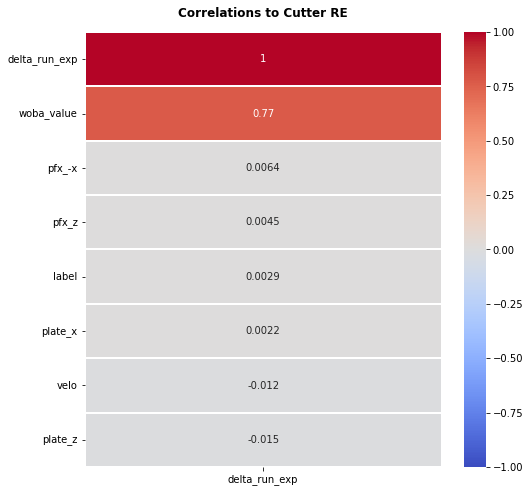

In [10]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter RE', fontweight = 'bold', pad = 15);

# Sinker

In [11]:
features_si = si.select_dtypes([np.number])
X_si = features_si

X_si_scaled = ss.fit_transform(X_si)
X_si_scaled[:,:] *= -1

pca = PCA().fit(X_si_scaled)
principal_components_si = pca.transform(X_si_scaled)
model_si = pd.DataFrame(data = principal_components_si, columns = X_si.columns)

km_si = KMeans(n_clusters = 2, 
               random_state = 1)

km_si.fit(model_si)
label_si = km_si.fit_predict(model_si)

print('Number of iterations:', km_si.n_iter_)
print('Number of features:', km_si.n_features_in_)
print('Number of clusters:', km_si.n_clusters)
print('Inertia:', km_si.inertia_, '\n')
print("Predicted clusters to points: ", label_si[:10], '\n')

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 619114.1661527505 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 1] 



### Cluster Labels - Sinker

In [12]:
# 0 bad, 1 good

X_si['label'] = label_si
model_si['label'] = label_si

X_si.groupby(by = 'label').mean().T

label,0,1
velo,92.984034,93.009306
pfx_-x,5.925047,5.616560
pfx_z,8.991775,9.256590
delta_run_exp,0.510040,-0.055920
woba_value,0.967467,0.000000
plate_x,-0.116970,-0.071817
plate_z,2.359687,2.332495


### Heatmap of Features - Sinker

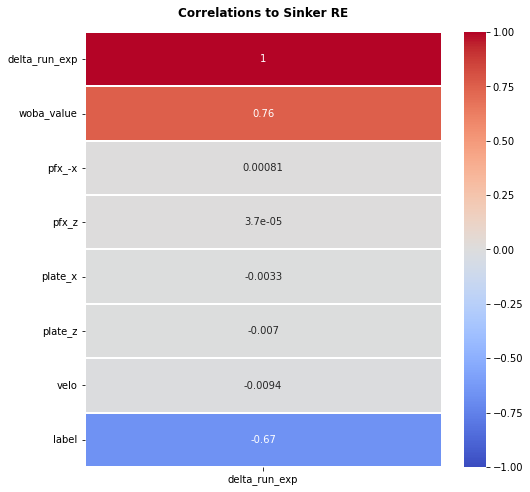

In [13]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_si.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Sinker RE', fontweight = 'bold', pad = 15);

## Slider

In [14]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)
model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')

Number of iterations: 5
Number of features: 7
Number of clusters: 2
Inertia: 768258.8055072734 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 1] 



### Cluster Labels - Slider

In [15]:
# 0 bad, 1 good

X_sl['label'] = label_sl
model_sl['label'] = label_sl

X_sl.groupby(by = 'label').mean().T

label,0,1
velo,84.677486,84.650161
pfx_-x,-3.145046,-3.227867
pfx_z,1.616998,1.710300
delta_run_exp,0.617844,-0.049092
woba_value,1.038080,0.001352
plate_x,0.113741,0.241411
plate_z,2.090473,1.870027


### Heatmap of Features - Slider

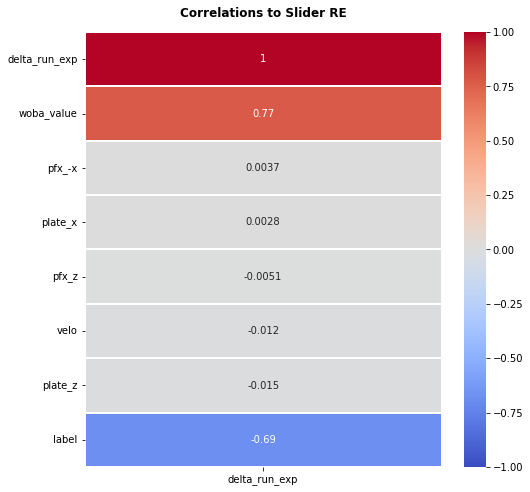

In [16]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider RE', fontweight = 'bold', pad = 15);

# Curveball

In [17]:
features_cu = cu.select_dtypes([np.number])
X_cu = features_cu

X_cu_scaled = ss.fit_transform(X_cu)
X_cu_scaled[:,:] *= -1

pca = PCA().fit(X_cu_scaled)
principal_components_cu = pca.transform(X_cu_scaled)
model_cu = pd.DataFrame(data = principal_components_cu, columns = X_cu.columns)

km_cu = KMeans(n_clusters = 2, 
               random_state = 1)

km_cu.fit(model_cu)
label_cu = km_cu.fit_predict(model_cu)

print('Number of iterations:', km_cu.n_iter_)
print('Number of features:', km_cu.n_features_in_)
print('Number of clusters:', km_cu.n_clusters)
print('Inertia:', km_cu.inertia_, '\n')
print("Predicted clusters to points: ", label_cu[:10], '\n')

Number of iterations: 4
Number of features: 7
Number of clusters: 2
Inertia: 331917.90441493475 

Predicted clusters to points:  [1 1 1 1 1 1 1 1 1 1] 



### Cluster Labels - Curveball

In [18]:
# 0 bad, 1 good

X_cu['label'] = label_cu
model_cu['label'] = label_cu

X_cu.groupby(by = 'label').mean().T

label,0,1
velo,78.607686,78.753530
pfx_-x,-3.524066,-3.884551
pfx_z,-8.777653,-8.738095
delta_run_exp,0.601095,-0.038624
woba_value,1.028140,0.000457
plate_x,0.012116,0.072239
plate_z,2.039716,1.819645


### Heatmaps of Features - Curveball

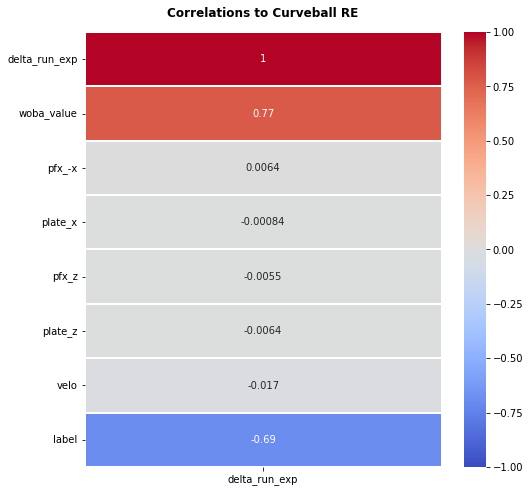

In [19]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_cu.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Curveball RE', fontweight = 'bold', pad = 15);

## Changeup

In [20]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch)
principal_components_ch = pca.transform(X_ch)
model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

km_ch = KMeans(n_clusters = 2, random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')

Number of iterations: 3
Number of features: 7
Number of clusters: 2
Inertia: 3874161.98662429 

Predicted clusters to points:  [0 0 0 0 0 0 0 0 0 0] 



### Cluster Labels - Changeup

In [21]:
# 0 good, 1 bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch

X_ch.groupby(by = 'label').mean().T

label,0,1
velo,85.531494,83.573328
pfx_-x,13.864524,-13.891458
pfx_z,6.279576,7.763038
delta_run_exp,0.002985,0.003150
woba_value,0.081480,0.086321
plate_x,-0.349740,0.486184
plate_z,1.838259,1.870819


### Heatmap of Features - Changeup

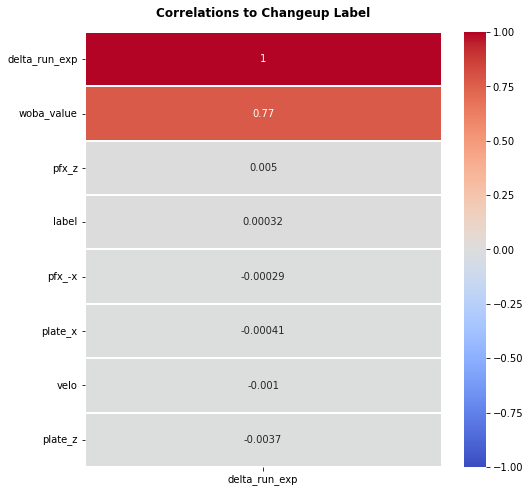

In [22]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['delta_run_exp']].sort_values(('delta_run_exp'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

# Modeling

## Linear Regression - 4-Seam

In [23]:
X = X_ff.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_ff['delta_run_exp']

ols_ff = sm.OLS(y, X)
ols_ff = ols_ff.fit()
pred_ff = ols_ff.predict(X)
ols_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                 5.461e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:52   Log-Likelihood:             1.1742e+05
No. Observations:              249672   AIC:                        -2.348e+05
Df Residuals:                  249664   BIC:                        -2.348e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0525      0.012     -4.549      0.000      -0.075      -0.030
velo          -0.0002      0.000     -1.945      0.052      -0.000    1.91e-06
pfx_-x      2.977e-05      4e-05      0.745      0.456   -4.85e-05       0.000
pfx_z        7.07e-05   9.29e-05      0.761      0.447      -0.000       0.000
woba_value     0.8286      0.003    322.837      0.000       0.824       0.834
plate_x        0.0013      0.000      3.181      0.001       0.000       0.002
plate_z        0.0092      0.000     26.200      0.000       0.009       0.010
label         -0.2643      0.003    -94.044      0.000      -0.270      -0.259
==============================================================================
Omnibus:                    56545.156   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2278173.723
Skew:                           0.297   Prob(JB):                         0.00
Kurtosis:                      17.786   Cond. No.                     3.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

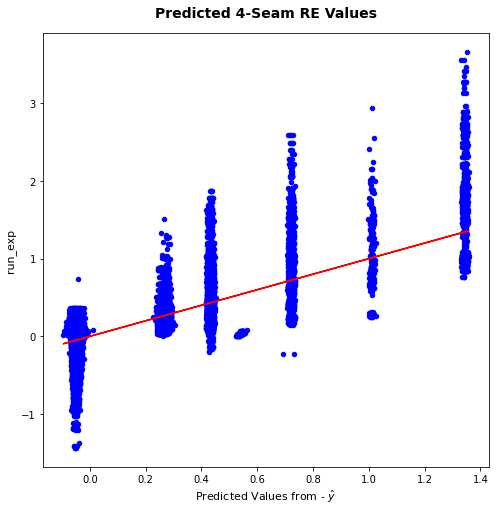

MSE: 0.0229
RMSE: 0.1512
MAE: 0.0947


In [24]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_ff, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ff, np.poly1d(np.polyfit(pred_ff, y, 1))(pred_ff), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted 4-Seam RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ff), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ff)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ff), 4))
#print('Cross val score', round(cross_val_score(model, X, y).mean(), 4))

## Linear Regression - Cutter

In [25]:
X = X_fc.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_fc['delta_run_exp']

ols_fc = sm.OLS(y, X)
ols_fc = ols_fc.fit()
pred_fc = ols_fc.predict(X)
ols_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     9778.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:53   Log-Likelihood:                 18990.
No. Observations:               47442   AIC:                        -3.796e+04
Df Residuals:                   47434   BIC:                        -3.789e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0370      0.024      1.558      0.119      -0.010       0.084
velo          -0.0009      0.000     -3.466      0.001      -0.001      -0.000
pfx_-x         0.0003      0.000      1.273      0.203      -0.000       0.001
pfx_z          0.0004      0.000      1.472      0.141      -0.000       0.001
woba_value     0.6426      0.002    261.501      0.000       0.638       0.647
plate_x        0.0063      0.001      6.870      0.000       0.005       0.008
plate_z       -0.0060      0.001     -7.033      0.000      -0.008      -0.004
label          0.0032      0.002      1.325      0.185      -0.002       0.008
==============================================================================
Omnibus:                    10644.523   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373630.325
Skew:                           0.349   Prob(JB):                         0.00
Kurtosis:                      16.730   Cond. No.                     2.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

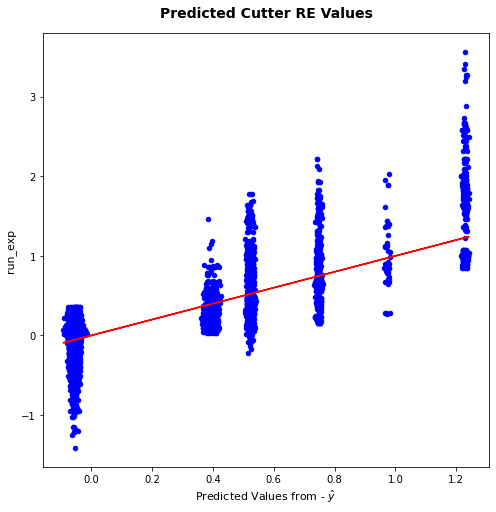

MSE: 0.0263
RMSE: 0.1622
MAE: 0.1037


In [26]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_fc, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_fc, np.poly1d(np.polyfit(pred_fc, y, 1))(pred_fc), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Cutter RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_fc), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_fc)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_fc), 4))

## Linear Regression - Sinker

In [27]:
X = X_si.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_si['delta_run_exp']

ols_si = sm.OLS(y, X)
ols_si = ols_si.fit()
pred_si = ols_si.predict(X)
ols_si.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 2.183e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:53   Log-Likelihood:                 42681.
No. Observations:              109145   AIC:                        -8.535e+04
Df Residuals:                  109137   BIC:                        -8.527e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2936      0.017    -17.486      0.000      -0.326      -0.261
velo          -0.0003      0.000     -1.618      0.106      -0.001    5.94e-05
pfx_-x     -1.835e-05   3.72e-05     -0.493      0.622   -9.12e-05    5.45e-05
pfx_z          0.0006      0.000      5.282      0.000       0.000       0.001
woba_value     0.8666      0.005    188.119      0.000       0.858       0.876
plate_x        0.0004      0.001      0.660      0.509      -0.001       0.002
plate_z       -0.0058      0.001     -9.134      0.000      -0.007      -0.005
label          0.2722      0.005     57.249      0.000       0.263       0.281
==============================================================================
Omnibus:                    19165.211   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           462325.662
Skew:                          -0.088   Prob(JB):                         0.00
Kurtosis:                      13.081   Cond. No.                     3.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

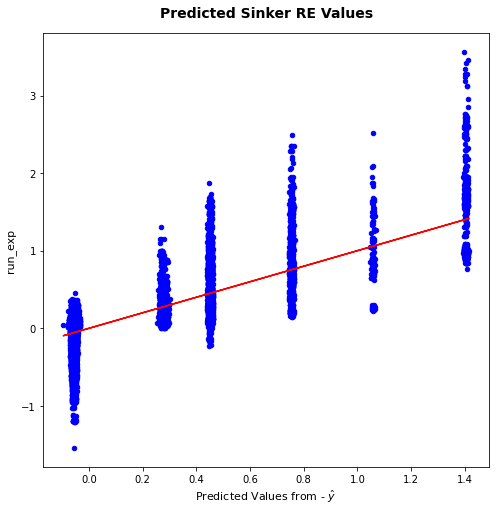

MSE: 0.0268
RMSE: 0.1637
MAE: 0.1055


In [28]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_si, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_si, np.poly1d(np.polyfit(pred_si, y, 1))(pred_si), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Sinker RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_si), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_si)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_si), 4))

## Linear Regression - Slider

In [29]:
X = X_sl.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_sl['delta_run_exp']

ols_sl = sm.OLS(y, X)
ols_sl = ols_sl.fit()
pred_sl = ols_sl.predict(X)
ols_sl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                 2.950e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:53   Log-Likelihood:                 59817.
No. Observations:              135539   AIC:                        -1.196e+05
Df Residuals:                  135531   BIC:                        -1.195e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0840      0.012     -7.224      0.000      -0.107      -0.061
velo          -0.0013      0.000    -10.670      0.000      -0.002      -0.001
pfx_-x         0.0002   6.09e-05      4.072      0.000       0.000       0.000
pfx_z          0.0003   9.83e-05      3.123      0.002       0.000       0.000
woba_value     0.8183      0.004    209.654      0.000       0.811       0.826
plate_x        0.0049      0.000      9.871      0.000       0.004       0.006
plate_z       -0.0165      0.000    -35.089      0.000      -0.017      -0.016
label          0.1771      0.004     40.488      0.000       0.169       0.186
==============================================================================
Omnibus:                    29245.794   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1011297.020
Skew:                           0.290   Prob(JB):                         0.00
Kurtosis:                      16.369   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

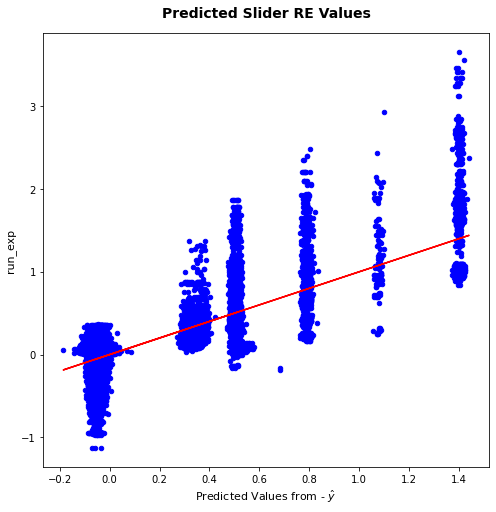

MSE: 0.0242
RMSE: 0.1556
MAE: 0.0998


In [30]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_sl, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_sl, np.poly1d(np.polyfit(pred_sl, y, 1))(pred_sl), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Slider RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_sl), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_sl)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_sl), 4))

## Linear Regression - Curveball

In [31]:
X = X_cu.drop(columns = ['delta_run_exp'])
X = sm.add_constant(X)
y = X_cu['delta_run_exp']

ols_cu = sm.OLS(y, X)
ols_cu = ols_cu.fit()
pred_cu = ols_cu.predict(X)
ols_cu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                 1.284e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:53   Log-Likelihood:                 32022.
No. Observations:               58767   AIC:                        -6.403e+04
Df Residuals:                   58759   BIC:                        -6.396e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1782      0.015    -12.151      0.000      -0.207      -0.149
velo          -0.0008      0.000     -5.219      0.000      -0.001      -0.001
pfx_-x      7.094e-05   5.97e-05      1.188      0.235   -4.61e-05       0.000
pfx_z       -8.04e-05      0.000     -0.776      0.438      -0.000       0.000
woba_value     0.8416      0.006    137.171      0.000       0.830       0.854
plate_x        0.0003      0.001      0.419      0.675      -0.001       0.002
plate_z       -0.0105      0.001    -18.735      0.000      -0.012      -0.009
label          0.2230      0.007     33.053      0.000       0.210       0.236
==============================================================================
Omnibus:                    15091.414   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           717860.068
Skew:                           0.441   Prob(JB):                         0.00
Kurtosis:                      20.099   Cond. No.                     2.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

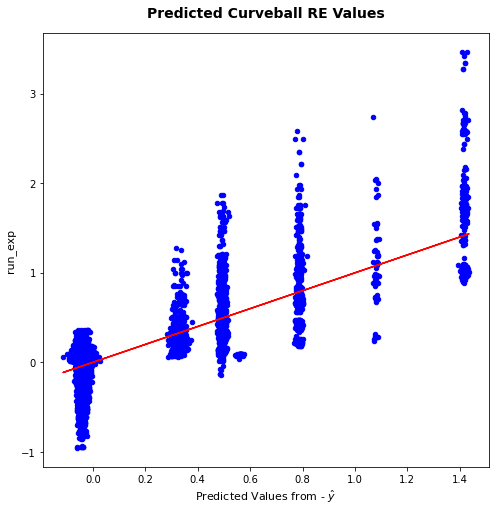

MSE: 0.0197
RMSE: 0.1403
MAE: 0.0879


In [32]:
plt.figure(figsize = (8, 8))

plt.scatter(pred_cu, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_cu, np.poly1d(np.polyfit(pred_cu, y, 1))(pred_cu), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Curveball RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_cu), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_cu)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_cu), 4))

## Linear Regression - Changeup

In [33]:
X = X_ch.drop(columns = ['delta_run_exp', 'label'])
X = sm.add_constant(X)
y = X_ch['delta_run_exp']

ols_ch = sm.OLS(y, X)
ols_ch = ols_ch.fit()
pred_ch = ols_ch.predict(X)
ols_ch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_run_exp   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                 2.000e+04
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:36:54   Log-Likelihood:                 33571.
No. Observations:               80322   AIC:                        -6.713e+04
Df Residuals:                   80315   BIC:                        -6.706e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0153      0.014     -1.066      0.286      -0.043       0.013
velo       -7.391e-05      0.000     -0.442      0.659      -0.000       0.000
pfx_-x      4.968e-05   4.77e-05      1.041      0.298   -4.38e-05       0.000
pfx_z          0.0005      0.000      4.523      0.000       0.000       0.001
woba_value     0.6504      0.002    346.410      0.000       0.647       0.654
plate_x       -0.0024      0.001     -3.262      0.001      -0.004      -0.001
plate_z       -0.0181      0.001    -28.262      0.000      -0.019      -0.017
==============================================================================
Omnibus:                    16481.940   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           482239.403
Skew:                           0.292   Prob(JB):                         0.00
Kurtosis:                      14.990   Cond. No.                     2.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

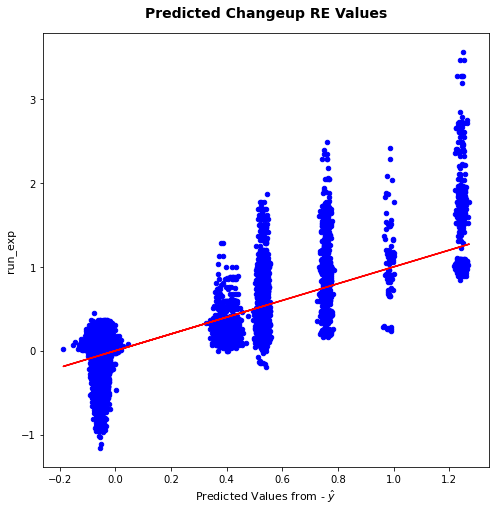

MSE: 0.0254
RMSE: 0.1593
MAE: 0.1057


In [34]:
plt.figure(figsize = (8, 8))
plt.scatter(pred_ch, y, s = 20, c = 'b', marker = 'o')
plt.plot(pred_ch, np.poly1d(np.polyfit(pred_ch, y, 1))(pred_ch), c = 'r')
plt.xlabel('Predicted Values from - $\hat{y}$', fontsize = 11), plt.ylabel('run_exp', fontsize = 11)
plt.title('Predicted Changeup RE Values', fontsize = 14, fontweight = 'bold', pad = 15), plt.show();
print('MSE:', round(metrics.mean_squared_error(y, pred_ch), 4))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred_ch)), 4))
print('MAE:', round(metrics.mean_absolute_error(y, pred_ch), 4))